ANALYSE PRICE DATA AND PREDICTION

C:\Users\bartb\AppData\Local\Temp\ipykernel_9740\536968100.py:11: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['Dates'] = pd.to_datetime(data['Dates'])


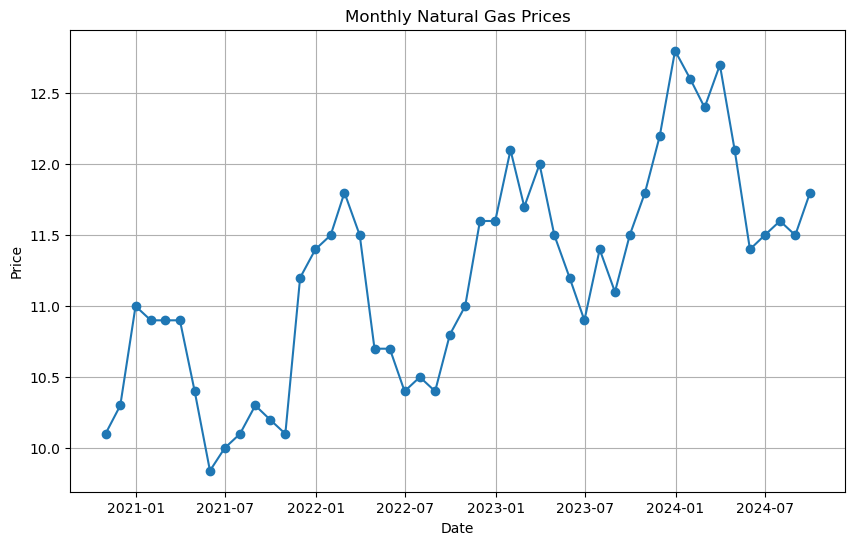

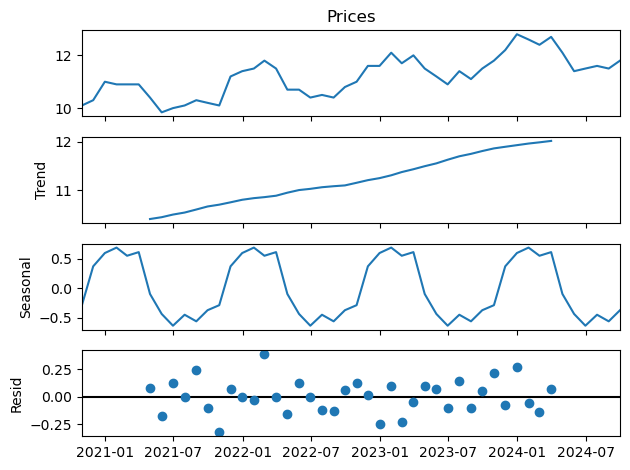

C:\Users\bartb\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
C:\Users\bartb\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
C:\Users\bartb\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)


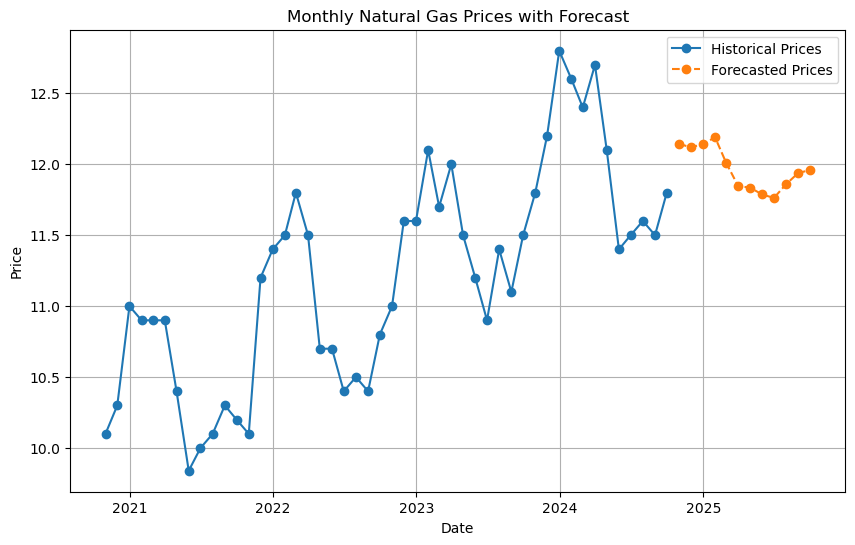

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from scipy.interpolate import interp1d

# Load the data
data = pd.read_csv("Nat_Gas.csv")

# Convert the 'Dates' column to datetime format
data['Dates'] = pd.to_datetime(data['Dates'])

# Set the 'Dates' column as the index
data.set_index('Dates', inplace=True)

# Plot the historical prices
plt.figure(figsize=(10, 6))
plt.plot(data.index, data['Prices'], marker='o', linestyle='-')
plt.title('Monthly Natural Gas Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.grid(True)
plt.show()

# Decompose the time series data
decomposition = seasonal_decompose(data['Prices'], model='additive', period=12)
decomposition.plot()
plt.show()

# Fit the ARIMA model
model = ARIMA(data['Prices'], order=(5, 1, 0))  # ARIMA(p,d,q) parameters can be tuned
model_fit = model.fit()

# Forecast for the next 12 months
forecast = model_fit.forecast(steps=12)

# Create a new DataFrame for the forecasted values
forecast_dates = pd.date_range(start=data.index[-1] + pd.DateOffset(months=1), periods=12, freq='M')
forecast_df = pd.DataFrame({'Prices': forecast}, index=forecast_dates)

# Plot the historical and forecasted prices
plt.figure(figsize=(10, 6))
plt.plot(data.index, data['Prices'], marker='o', linestyle='-', label='Historical Prices')
plt.plot(forecast_df.index, forecast_df['Prices'], marker='o', linestyle='--', label='Forecasted Prices')
plt.title('Monthly Natural Gas Prices with Forecast')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

# Function to estimate the price for a given date
def estimate_price(date):
    date = pd.to_datetime(date)
    
    if date in data.index:
        return data.loc[date, 'Prices']
    elif date > data.index[-1]:
        # Use the ARIMA forecast for future dates
        if date in forecast_df.index:
            return forecast_df.loc[date, 'Prices']
        else:
            return None  # Date is beyond the forecast range
    else:
        # Interpolate for past dates not in the data
        interp_func = interp1d(data.index.toordinal(), data['Prices'], fill_value='extrapolate')
        return interp_func(date.toordinal())

PRICE A COMMODITY STORAGE CONTRACT

In [1]:
from datetime import date
import math

def price_contract(in_dates, in_prices, out_dates, out_prices, rate, storage_cost_rate, total_vol, injection_withdrawal_cost_rate):
    volume = 0
    buy_cost = 0
    cash_in = 0
    last_date = min(min(in_dates), min(out_dates))
    
    # Ensure dates are in sequence
    all_dates = sorted(set(in_dates + out_dates))
    
    for i in range(len(all_dates)):
        # processing code for each date
        start_date = all_dates[i]

        if start_date in in_dates:
            # Inject on these dates and sum up cash flows
            if volume <= total_vol - rate:
                volume += rate

                # Cost to purchase gas
                buy_cost += rate * in_prices[in_dates.index(start_date)]
                # Injection cost
                injection_cost = rate * injection_withdrawal_cost_rate
                buy_cost += injection_cost
                print('Injected gas on %s at a price of %s'%(start_date, in_prices[in_dates.index(start_date)]))

            else:
                # We do not want to inject when rate is greater than total volume minus volume
                print('Injection is not possible on date %s as there is insufficient space in the storage facility'%start_date)
        elif start_date in out_dates:
            #Withdraw on these dates and sum cash flows
            if volume >= rate:
                volume -= rate
                cash_in += rate * out_prices[out_dates.index(start_date)]
                # Withdrawal cost
                withdrawal_cost = rate * injection_withdrawal_cost_rate
                cash_in -= withdrawal_cost
                print('Extracted gas on %s at a price of %s'%(start_date, out_prices[out_dates.index(start_date)]))
            else:
                # we cannot withdraw more gas than is actually stored
                print('Extraction is not possible on date %s as there is insufficient volume of gas stored'%start_date)
                
    store_cost = math.ceil((max(out_dates) - min(in_dates)).days // 30) * storage_cost_rate
    return cash_in - store_cost - buy_cost

# Example usage of price_contract()
in_dates = [date(2022, 1, 1), date(2022, 2, 1), date(2022, 2, 21), date(2022, 4, 1)] #injection dates
in_prices = [20, 21, 20.5, 22]#prices on the injection days
out_dates = [date(2022, 1, 27), date(2022, 2, 15), date(2022, 3, 20), date(2022, 6, 1)] # extraction dates
out_prices = [23, 19, 21, 25] # prices on the extraction days
rate = 100000  # rate of gas in cubic feet per day
storage_cost_rate = 10000  # total volume in cubic feet
injection_withdrawal_cost_rate = 0.0005  # $/cf
max_storage_volume = 500000 # maximum storage capacity of the storage facility
result = price_contract(in_dates, in_prices, out_dates, out_prices, rate, storage_cost_rate, max_storage_volume, injection_withdrawal_cost_rate)
print()
print(f"The value of the contract is: ${result}")


Injected gas on 2022-01-01 at a price of 20
Extracted gas on 2022-01-27 at a price of 23
Injected gas on 2022-02-01 at a price of 21
Extracted gas on 2022-02-15 at a price of 19
Injected gas on 2022-02-21 at a price of 20.5
Extracted gas on 2022-03-20 at a price of 21
Injected gas on 2022-04-01 at a price of 22
Extracted gas on 2022-06-01 at a price of 25

The value of the contract is: $399600.0
